In [1]:
import rasterio as rio
import cufflinks as cf
import numpy as np
import rioxarray as riox
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from ipywidgets import interact, Button
from plotly.offline import init_notebook_mode, plot, iplot
from sklearn import preprocessing
import scipy as sp
import plotly.express as px
from specutils import Spectrum1D
import astropy.units as u
import numpy as np
import cv2
import os.path
import pysptools.spectro as spectro
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
from sympy import *
import M3spectral.preparation
import M3spectral.plotting
import M3spectral.filtration
import M3spectral.indexes

# Importing data and preparation

In [2]:
#Defining the paths
path_data='/home/jovyan/work/Index/data'
path_results='/home/jovyan/work/Index/results'
target='M3_Valentine_full1'

This M3 cube is already proccesed to level 2, hence its values are reflectance and is map projected (see USGS ISIS3)

In [3]:
#Import data: raster and wavelengths
imput_cube=riox.open_rasterio(f'{path_data}/{target}.tif')  
wavelengths_full=np.loadtxt(f'{path_data}/Wavelength.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it

In [4]:
#This function attach the wavelength to the cube, sets the no value data to 0 and deletes the two first malfunctioning bands, and the bands after 2700 nm
M3_cubenocrop=M3spectral.preparation.attach_wavelen(imput_cube,wavelengths_full)

The data needs to have a rectangular shape, it is neccesary to properly do the fourier filtration, be carefull to not catch no value data

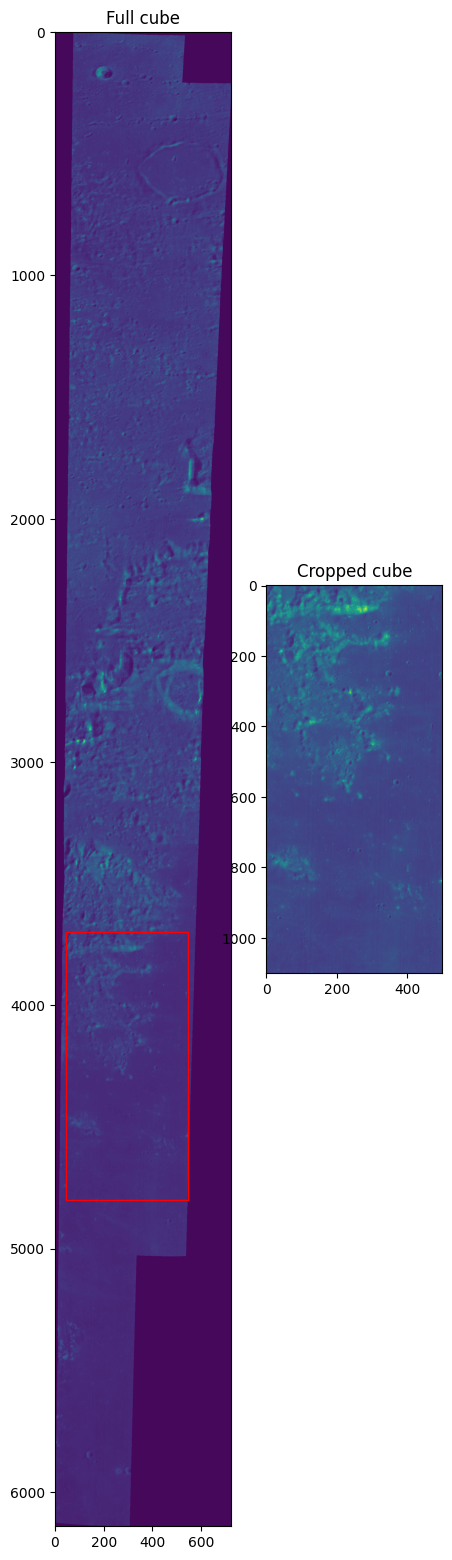

In [5]:
#Cropping the data 
M3_cube=M3spectral.preparation.crop_cube(M3_cubenocrop,45,545,3700,4800)  #Inputs are the cubes and the coordinates of the cropping rectangle (x limits and y limits)

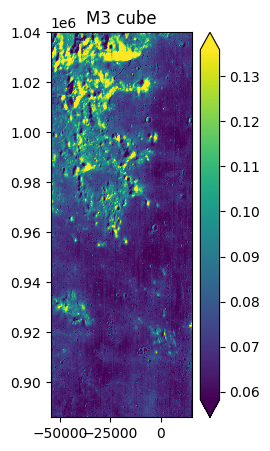

In [6]:
#Viewing the data, arguments are the cube, the band and the size
M3spectral.plotting.cube_plot(M3_cube,35,5,'M3 cube')

In [7]:
#Defining the shape of the cube, x=bands, y=vertical, z=horizontal
x,y,z=M3_cube.shape
x,y,z

(83, 1100, 500)

# Smoothing of the Spectra

M3 data shows vertical stripes that sometimes make it difficult to see the scientific information. Shkuratov et al. (2019) developed a workflow to enhance the quality of the data, which include a fourier and a gaussian filtration. While checking the efect of the fitlers to the indexes, we found that some are better without certain filtrations, so some indexes have diferent imputs.

To check that actual data is not being lost during the filtering, we check first the ratio beetwen the input and ooutput, it should show lunar features if data is being lost. And second, we mapped the pixels that changed more than 2% after the filter, which are the pixel mapped as 0. As seen in both cases, the affected information is related to the verticla stripes and not the spectral data. 

/home/jovyan/work/Index/scripts/M3spectral/plotting.py:50: RuntimeWarning:

divide by zero encountered in log



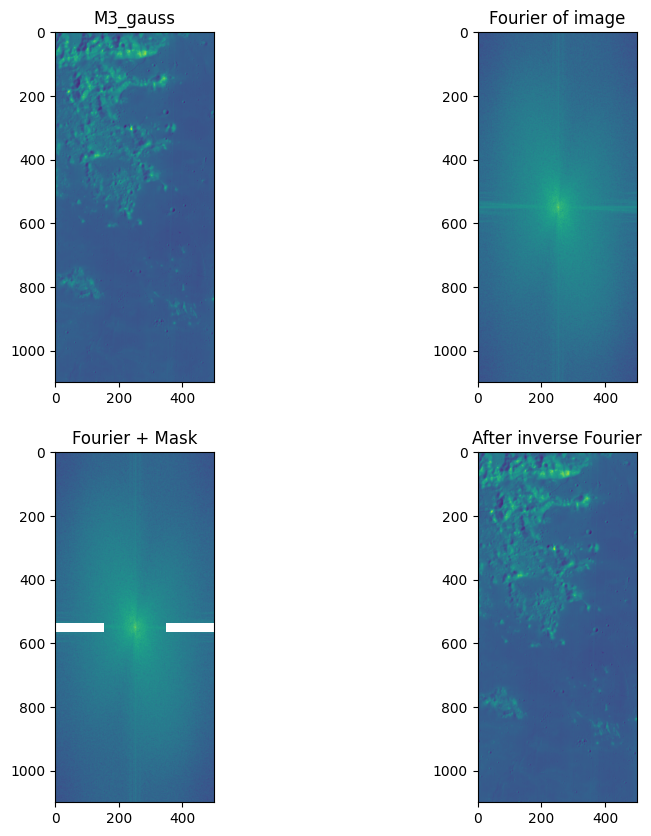

In [8]:
#Doing a fourier filtration, maybe put the filter to 30 percent of the large
M3_fourier=M3spectral.filtration.fourier_filter(M3_cube,60,2)  #Inputs the cube, and width and altitude of the mask in total percentage

#Plotting to check
M3spectral.plotting.fourier_plot(M3_cube,67,60,2)  #Inputs the cube, band, and width and altitude of the mask in total percentage

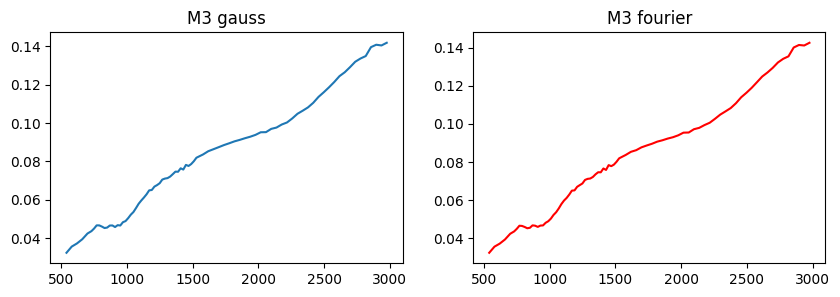

In [9]:
#Comparing a spectral signature before and after the gaussian fitler
M3spectral.plotting.profiles_comparison(wavelengths_full,M3_cube.data,M3_fourier.data,"M3 gauss","M3 fourier", 45,734,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi

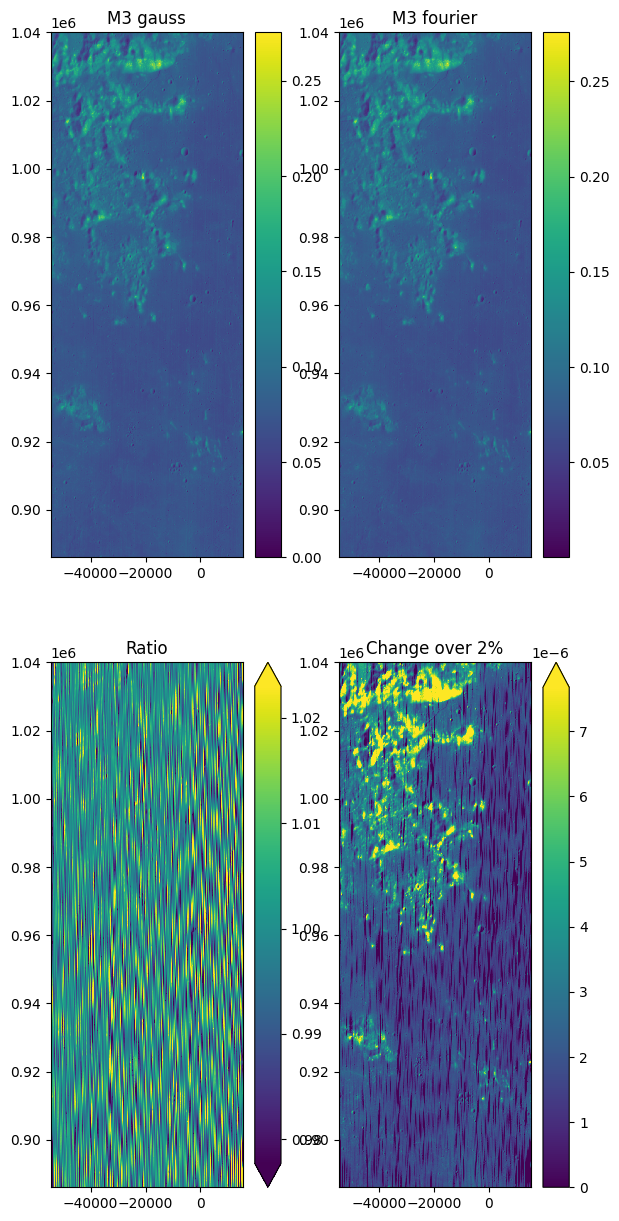

In [10]:
#Plotting the images to compare
M3spectral.plotting.filter_comaprison(M3_cube,M3_fourier,"M3 gauss", "M3 fourier",40) #Inputs are the cubes to compare, their names, and the band

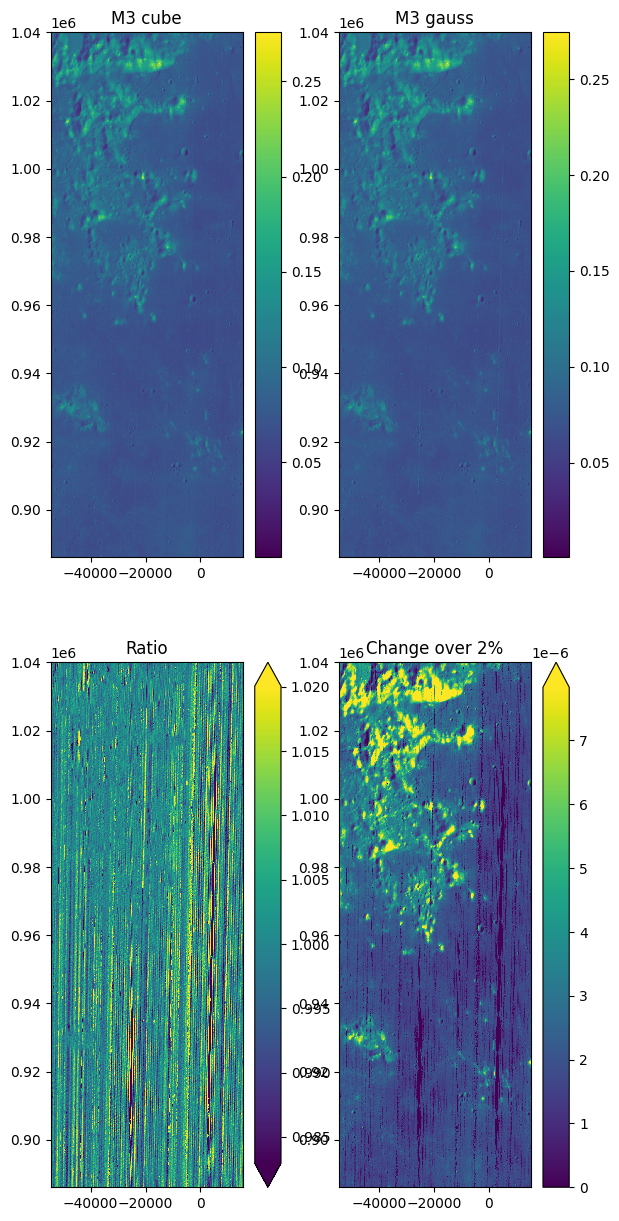

In [11]:
#Doing a gaussian filtration
M3_gauss=M3spectral.filtration.gauss_filter(M3_fourier,wavelengths_full)  #Inputs are the original cube and wavelengths

#Plotting the images to compare
M3spectral.plotting.filter_comaprison(M3_fourier,M3_gauss,"M3 cube", "M3 gauss",40) #Inputs are the cubes to compare, their names, and the band

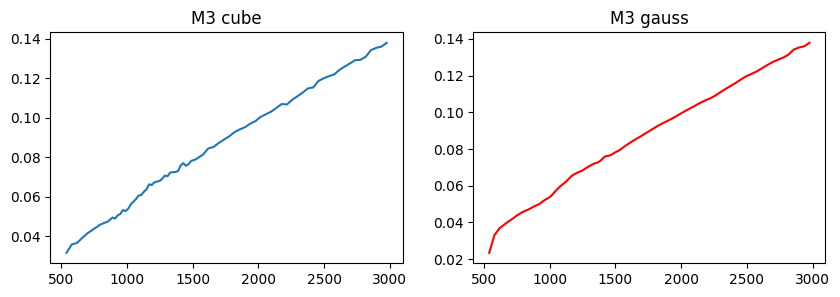

In [12]:
#Comparing a spectral signature before and after the gaussian fitler
M3spectral.plotting.profiles_comparison(wavelengths_full,M3_fourier.data,M3_gauss.data,"M3 cube","M3 gauss",70, 745,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi

# Continuum removal with the convex hull method

In order to obtain the indexes, it is neccesary to extract the continuum of the spectra to properly locate the absorption centers, shoulders and shapes. There are several methos to do it, but we opted for the convex hull removal method, following Shkuratov et al. (2019), as it is straighforward and correctly derives the shape of the spectrum. A problem of M3 spectra is that the upwards trend make the dificult the convex hull aplication, to solve that we previously created a point with the local maxima between 1000 and 1500 nm, so it could be added to the convex hull and the absorption peak would not be distorded.

In [13]:
#Function to find the midpoint to add to the convexhull
M3_midpoint=M3spectral.preparation.midpoint(M3_gauss,wavelengths_full,6,0.002)  #Inputs are the filtered cube, the wavelengths, and the distance and prominence of the peaks

In [14]:
#Function to remove the continnum by the convex hull method, it is computed only until 2700 nm
M3_hull = M3spectral.preparation.convexhull_removal(M3_gauss,wavelengths_full, M3_midpoint)  #Inputs are the filtered cube, wavelengths and the midpoint

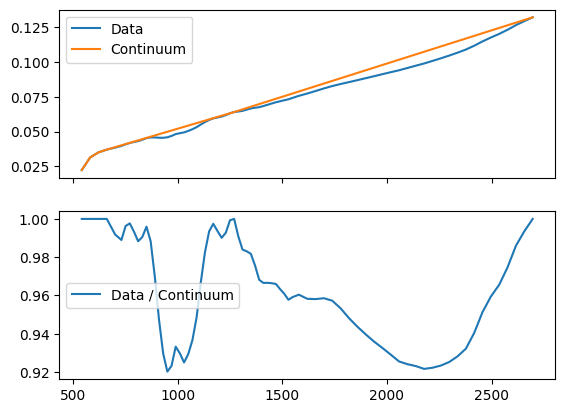

In [15]:
#Convex hull plotting
M3spectral.plotting.convexhull_plot(M3_gauss.data,wavelengths_full, M3_midpoint.data,480,890) #Inputs are filtered cube, wavelengths, midpoint,x, y and ROI

In [16]:
#Exporting the continumm removed cube
M3_hull.rio.to_raster(f'{path_results}/M3_{target}_conremoved.tif') 

The band minimuum is a key value to create the indexes. This function looks for the minimuum value of the continuum removed cube between 540 nm and 1209.57 nm for the 1000 nm minimuum, and between 1329.34 nm and 2696.73 nm for the 2000 nm minimuum. Then it stores the wavelength of that point. The intervals were asigned from the literature (Clenet, 2009) regarding the absoprtions of olivine, ca-pyroxene and mg-pyroxene; and refined by manual comparison. 

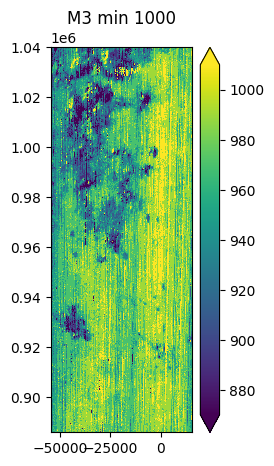

In [17]:
# Making rasters with the wavelength of minimum reflectance in 1000 um and 2000 um respectively
M3_min1000, M3_min2000=M3spectral.preparation.find_minimums_ch(M3_hull,M3_midpoint,wavelengths_full)  #Inputs are the convex hull and wavelengths, outputa the two minimums

#Plotting to check
M3spectral.plotting.image_plot(M3_min1000,5,'M3 min 1000')

The other key value to make the indexes are the band shoulders. This function looks in the continuum removed cube for the maximums between 540 nm and 1029.91 nm, and between 1029.91 nm and 1429.15 nm, for the left and right shoulders of the 1000 nm minimuum respectively. Then between 1429.15 nm and 2337.42 nm, and between 2337.42 nm and 2736.65 nm, for the left and right shoulders of the 2000 nm minimuum respectively. These intervals were defined manually.

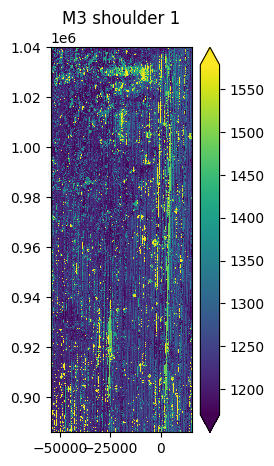

In [18]:
#Obtaining the shoulders, point of maximum reflectance beetween the minimum
M3_shoulder0, M3_shoulder1, M3_shoulder2, M3_shoulder3=M3spectral.preparation.find_shoulders_ch(M3_hull,M3_midpoint,M3_min1000,M3_min2000,wavelengths_full)  #Inputs convex hull and wavelengths, outputs the four shoulders

#Plotting to check
M3spectral.plotting.image_plot(M3_shoulder1,5,'M3 shoulder 1')

# Indexes - General

These indexes were colected in the literature, mainly from Zambon et al. (2020), but also from Bretzfelder et al. (2020), Corley et al. (2018), and Horgan et al. (2014).

This is a general index to detect olivine, it operates over some bands (Corley et al., 2018).

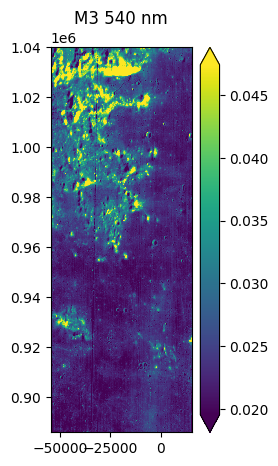

In [19]:
#R540, reflectance at 540 nm
M3_R540=M3spectral.indexes.R540(M3_gauss) #Input filtered cube
M3_R540.rio.to_raster(f'{path_results}/M3_{target}_R540.tif')
M3spectral.plotting.image_plot(M3_R540,5,'M3 540 nm')

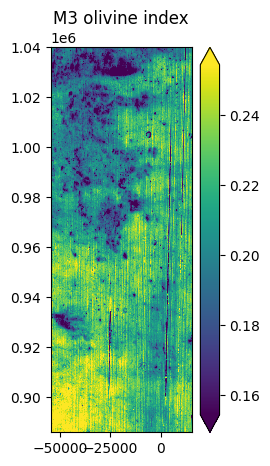

In [20]:
#Olivine detection index
M3_ol=M3spectral.indexes.olivine(M3_gauss)  #Input filtered cube
M3_ol.rio.to_raster(f'{path_results}/M3_{target}_Ol.tif')
M3spectral.plotting.image_plot(M3_ol,5,'M3 olivine index')

# Indexes - Convex hull

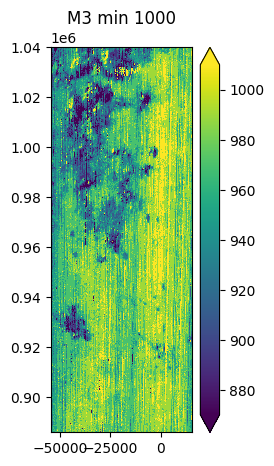

In [21]:
#BCI, Band minimum at 1000
M3_min1000.rio.to_raster(f'{path_results}/M3_{target}_BCI_CH.tif')
M3spectral.plotting.image_plot(M3_min1000,5,'M3 min 1000')

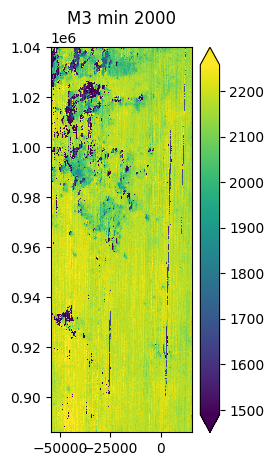

In [22]:
#BCII, Band minimum at 2000
M3_min2000.rio.to_raster(f'{path_results}/M3_{target}_BCII_CH.tif')
M3spectral.plotting.image_plot(M3_min2000,5,'M3 min 2000')

The band depth is obtained by dividing the reflectance by the value of the continnum at that location, always positive. The spectral slope of 1000 nm is calculated between the 540 nm band and the first shoulder (Zambon et al., 2020). (Zambon et al., 2020). This indexes and the derived RGB1 show better results whitout the gaussian filter.

#BDI, band depth at 1000 nm with the linear fit removal method
M3_BDI=M3spectral.indexes.LFBDI(M3_gauss,M3_hullg,wavelengths)  #Inputs fitlered cube, hull and wavelengths, outputs the BDI
M3_BDI.rio.to_raster(f'{path_results}/M3_{target}_BDI.tif')
M3spectral.plotting.image_plot(M3_BDI,5)

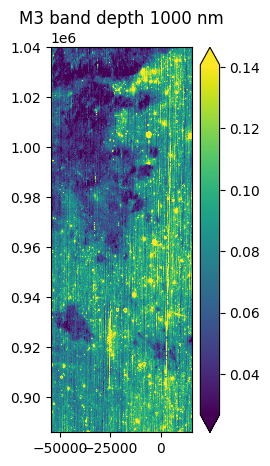

In [23]:
#BDI, band depth at 1000 nm with the convex hull method
M3_CHBDI=M3spectral.indexes.BDI(M3_hull,M3_min1000,wavelengths_full)
M3_CHBDI.rio.to_raster(f'{path_results}/M3_{target}_BDI_CH.tif')
M3spectral.plotting.image_plot(M3_CHBDI,5,'M3 band depth 1000 nm')

#BDII, band depth at 2000 nm with the linear fit removal method
M3_BDII=M3spectral.indexes.LFBDII(M3_gauss,M3_hullg,wavelengths)  #Inputs fitlered cube, hull and wavelengths, outputs the BDI
M3_BDII.rio.to_raster(f'{path_results}/M3_{target}_BDII.tif')
M3spectral.plotting.image_plot(M3_BDII,5)

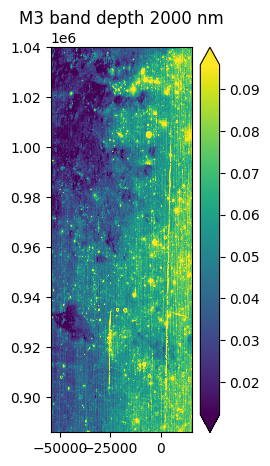

In [24]:
#BDII, band depth at 2000 nm with the convex hull method
M3_CHBDII=M3spectral.indexes.BDII(M3_hull,M3_min2000,wavelengths_full)
M3_CHBDII.rio.to_raster(f'{path_results}/M3_{target}_BDII_CH.tif')
M3spectral.plotting.image_plot(M3_CHBDII,5,'M3 band depth 2000 nm')

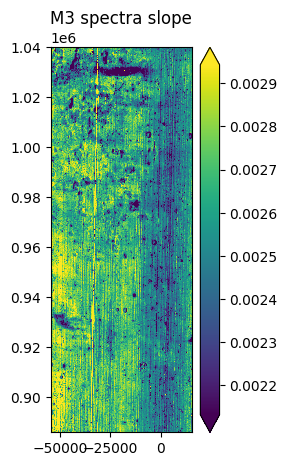

In [25]:
#SS1000, Spectral slope between maximun right shoulder and 540nm
M3_SSI=M3spectral.indexes.SSI(M3_gauss,M3_shoulder1,wavelengths_full) #Inputs are filtered cube, hull and wavelengths
M3_SSI.rio.to_raster(f'{path_results}/M3_{target}_SSI.tif')
M3spectral.plotting.image_plot(M3_SSI,5,'M3 spectra slope')

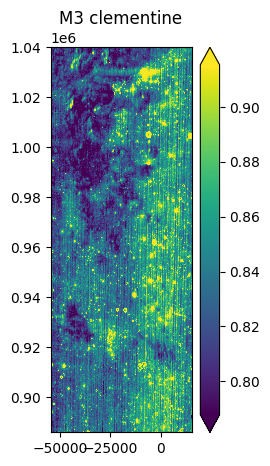

In [26]:
#Clementine-like RGB. R: R750 nm/R540 nm, G:,R750 nm/R1000 nm, B:R540nm/R750 nm
M3_clem=M3spectral.indexes.clementine(M3_gauss) #Inputs filtered cube
M3_clem.rio.to_raster(f'{path_results}/M3_{target}_CLEM.tif')
M3spectral.plotting.cube_plot(M3_clem,1,5,'M3 clementine')

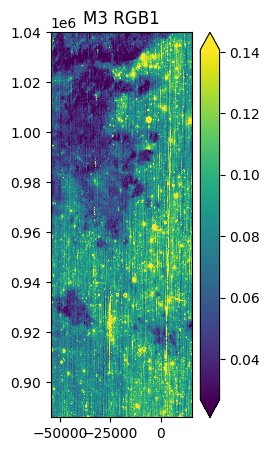

In [27]:
#RGB1. R: SSI, G: BDI, B: BDII. Better whitout gaussian
M3_RGB1=M3spectral.indexes.RGB1(M3_gauss,M3_SSI,M3_CHBDI,M3_CHBDII) #Inputs filtered cube, SSI, BDI, BDII
M3_RGB1.rio.to_raster(f'{path_results}/M3_{target}_RGB1.tif')
M3spectral.plotting.cube_plot(M3_RGB1,1,5,'M3 RGB1')

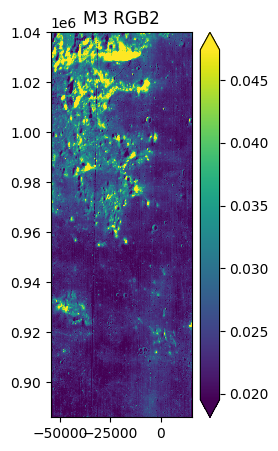

In [28]:
#RGB2. R: SSI, G: R540 nm, B: BCII.
M3_RGB2=M3spectral.indexes.RGB2(M3_gauss, M3_SSI, M3_R540, M3_min2000)  #Inputs filtered cube, SSI, R540, BCII
M3_=M3_RGB2.rio.to_raster(f'{path_results}/M3_{target}_RGB2.tif')
M3spectral.plotting.cube_plot(M3_RGB2,1,5,'M3 RGB2')

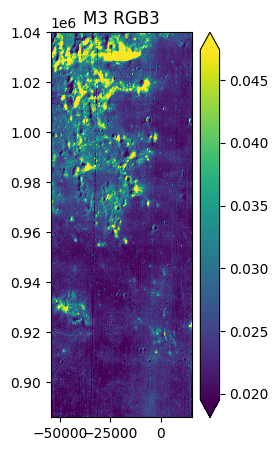

In [29]:
#RGB3. R: SSBI, G: R540 nm, B: BCI.
M3_RGB3=M3spectral.indexes.RGB3(M3_gauss,M3_SSI, M3_R540,M3_min1000) #Inputs filtered cube, SSI, R540, BCI
M3_RGB3.rio.to_raster(f'{path_results}/M3_{target}_RGB3.tif')
M3spectral.plotting.cube_plot(M3_RGB3,1,5,'M3 RGB3')

The indexes RGB4 and 5 use parameters focused on the shape of the spectra, the band area and asymmetry. The first one is calcualted by aproximation using the method of adding rectangles areas, and the second one calculates the area at both sides of the band centers and then asign the diference as a percentage (Horgan et al., 2014).  

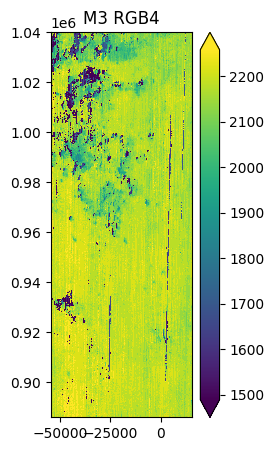

In [30]:
#RGB4. R:BCI, G: BCII, B:BAI, this index combines the band centers wit the band area at 1000 nm
M3_RGB4=M3spectral.indexes.RGB4(M3_gauss,wavelengths_full,M3_shoulder0,M3_shoulder1,M3_min1000,M3_min2000)  #Inputs are Filtered cube, wavelengths, shoudlers 0 and 1,min 1000 and 2000
M3_RGB4.rio.to_raster(f'{path_results}/M3_{target}_RGB4.tif')
M3spectral.plotting.cube_plot(M3_RGB4,1,5,'M3 RGB4')

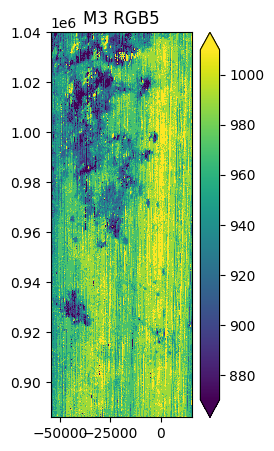

In [31]:
#RGB5. R:ASY, G:BCI, B: BCII, this index combines the band asymmetry at 1000 with the center at 2000 and the band area at 1000
M3_RGB5=M3spectral.indexes.RGB5(M3_gauss,wavelengths_full, M3_shoulder0,M3_shoulder1,M3_min1000,M3_min2000) #Inputs are filtered cube, wavelengths, shoudlers 0 and 1, minimmuns 1000 and 2000, and the band area 9calculated in a prior step)
M3_RGB5.rio.to_raster(f'{path_results}/M3_{target}_RGB5.tif')
M3spectral.plotting.cube_plot(M3_RGB5,1,5,'M3 RGB5')

The NIR index use the integrated band depths at 1000 nm and 2000 nm, those is similar to the band depth, but the operation is done at a range of wavelengths (Bretzfelder et al., 2020). The 2000 nm is calculated between 1658.71 nm and 2497.11 nm, and the 1000 nm is calculated between 790.37 nm and 1309.38 nm.    

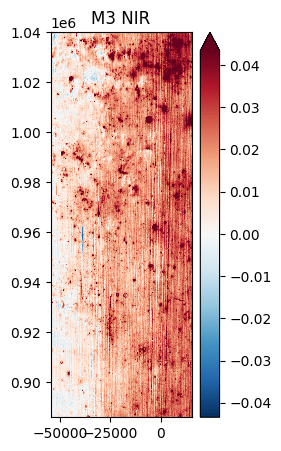

In [32]:
#NIR. R: band depth (BD) 1900, integrated band depth(IBD) 2000, integrated band depth (IBD) 1000
M3_NIR=M3spectral.indexes.CH_NIR(M3_gauss,M3_hull)
M3_NIR.rio.to_raster(f'{path_results}/M3_{target}_NIR.tif')
M3spectral.plotting.cube_plot(M3_NIR,0,5,'M3 NIR')

# Linear fit continuum removal method

The difference here is that the band depth is calcualted not directly in the convexhull, instead it is the result of a linear fit beetwen the shoulders of the spectra. We still use the position obtained by searching in the midpoint.

SELECT THE SHOUDLERS DIRECTLY (OR AFTER TREND REMOVAL) IN THOSE RANGES AND THEN REMOVE THE CONTINUM BY MERGING THE TWO FUNCTIONS (2 ORDER AT 1000 NM AND 1 ORDER AT 2000 NM)

Shoulder 1: 580-770 nm Shoulder2: 1400-1469 nm Shoulder3: 2656 nm

In [34]:
#Continuum removal with the linear fit method
M3_lf=M3spectral.preparation.continuum_removal_lf(M3_gauss,wavelengths_full)

In [35]:
#Minimuums calculation with the linear fit method
M3_min1000lf,M3_min2000lf=M3spectral.preparation.find_minimuumslf(M3_lf,wavelengths_full)

In [36]:
#Maximums calculation with the linear fit method
M3_shoulder0lf,M3_shoulder1lf,M3_shoulder2lf=M3spectral.preparation.find_shoulders_lf(M3_lf,M3_min1000lf,M3_min2000lf,wavelengths_full)

# Indexes - Linear fit

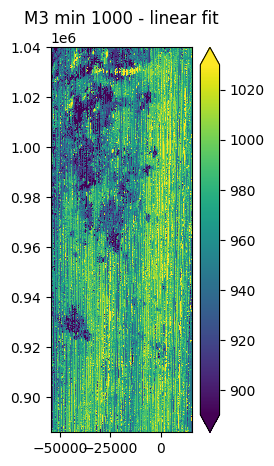

In [37]:
#BCI, Band minimum at 1000 linear-fit
M3_min1000lf.rio.to_raster(f'{path_results}/M3_{target}_BCI_LF.tif')
M3spectral.plotting.image_plot(M3_min1000lf,5,'M3 min 1000 - linear fit')

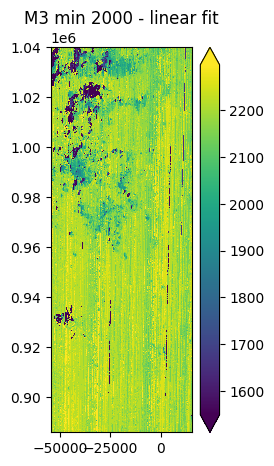

In [38]:
#BCII, Band minimum at 2000 linear-fit
M3_min2000lf.rio.to_raster(f'{path_results}/M3_{target}_BCII_LF.tif')
M3spectral.plotting.image_plot(M3_min2000lf,5,'M3 min 2000 - linear fit')

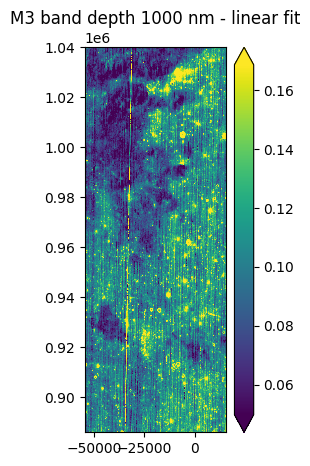

In [39]:
#BDI, band depth at 1000 nm with the linear fit method
M3_BDI_LF=M3spectral.indexes.BDI(M3_lf,M3_min1000lf,wavelengths_full)
M3_BDI_LF.rio.to_raster(f'{path_results}/M3_{target}_BDI_LF.tif')
M3spectral.plotting.image_plot(M3_BDI_LF,5,'M3 band depth 1000 nm - linear fit')

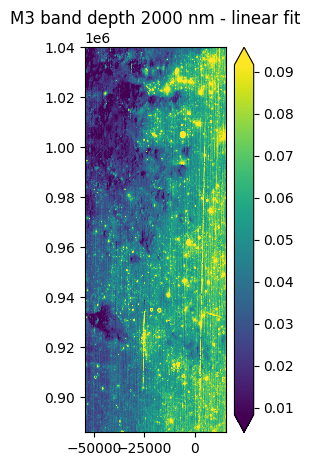

In [40]:
#BDI, band depth at 1000 nm with the convex hull method
M3_BDII_LF=M3spectral.indexes.BDII(M3_lf,M3_min2000lf,wavelengths_full)
M3_BDII_LF.rio.to_raster(f'{path_results}/M3_{target}_BDII_LF.tif')
M3spectral.plotting.image_plot(M3_BDII_LF,5,'M3 band depth 2000 nm - linear fit')

# References

Bretzfelder, J. M., Klima, R. L., Greenhagen, B. T., Buczkowski, D. L., Petro, N. E., & Day, M. (2020). Identification of Potential Mantle Rocks Around the Lunar Imbrium Basin. Geophysical Research Letters, 47(22). https://doi.org/10.1029/2020GL090334

Clenet, H. (2009). Télédétection hyperspectrale: Minéralogie et pétrologie, Application au volcan Syrtis Major (Mars) et à l’ophiolite d’Oman. Université de Toulouse.

Corley, L. M., McGovern, P. J., Kramer, G. Y., Lemelin, M., Trang, D., Gillis-Davis, J. J., Taylor, G. J., Powell, K. E., Kiefer, W. S., Wieczorek, M., & Zuber, M. T. (2018). Olivine-bearing lithologies on the Moon: Constraints on origins and transport mechanisms from M3 spectroscopy, radiative transfer modeling, and GRAIL crustal thickness. Icarus, 300, 287-304. https://doi.org/10.1016/j.icarus.2017.09.012

Horgan, B. H. N., Cloutis, E. A., Mann, P., & Bell, J. F. (2014). Near-infrared spectra of ferrous mineral mixtures and methods for their identification in planetary surface spectra. Icarus, 234, 132-154. https://doi.org/10.1016/j.icarus.2014.02.031

Shkuratov, Yu., Surkov, Ye., Ivanov, M., Korokhin, V., Kaydash, V., Videen, G., Pieters, C., & Stankevich, D. (2019). Improved Chandrayaan-1 M3 data: A northwest portion of the Aristarchus Plateau and contiguous maria. Icarus, 321, 34-49. https://doi.org/10.1016/j.icarus.2018.11.002

Zambon, F., Carli, C., Altieri, F., Luzzi, E., Combe, J.-P., Ferrari, S., Tognon, G., & Massironi, M. (2020). Spectral Index and RGB maps—Beethoven, Rembrandt basins on Mercury, Apollo basin and Leibnitz and Von Karman craters regions on the Moon (p. 57).
